In [105]:
from pytorch_tabnet.tab_model import TabNetClassifier

import os
import torch
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
 
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [106]:
historical_standings_pl = pd.read_csv('data/Premier/premier-league-standing-1993-2023.csv')

print(historical_standings_pl.columns)

Index(['Season_End_Year', 'Team', 'Rk', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD',
       'Pts', 'Notes'],
      dtype='object')


In [107]:
#columna Notes no aporta.
historical_standings_pl = historical_standings_pl.drop(columns=['Notes'])
print(historical_standings_pl.columns)

Index(['Season_End_Year', 'Team', 'Rk', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD',
       'Pts'],
      dtype='object')


In [108]:
#Revisamos la cantidad y los nombres de los equipos
print(historical_standings_pl['Team'].unique())
print("\ncantidad: ", len(historical_standings_pl['Team'].unique()))

['Arsenal' 'Aston Villa' 'Blackburn' 'Chelsea' 'Coventry City'
 'Crystal Palace' 'Everton' 'Ipswich Town' 'Leeds United' 'Liverpool'
 'Manchester City' 'Manchester Utd' 'Middlesbrough' 'Norwich City'
 "Nott'ham Forest" 'Oldham Athletic' 'QPR' 'Sheffield Utd'
 'Sheffield Weds' 'Southampton' 'Tottenham' 'Wimbledon' 'Newcastle Utd'
 'Swindon Town' 'West Ham' 'Leicester City' 'Bolton' 'Derby County'
 'Sunderland' 'Barnsley' 'Charlton Ath' 'Bradford City' 'Watford' 'Fulham'
 'Birmingham City' 'West Brom' 'Portsmouth' 'Wolves' 'Wigan Athletic'
 'Reading' 'Hull City' 'Stoke City' 'Burnley' 'Blackpool' 'Swansea City'
 'Cardiff City' 'Bournemouth' 'Brighton' 'Huddersfield' 'Brentford']

cantidad:  50


In [109]:
#Cargar archivo de los partidos
matches = pd.read_csv('data/Premier/premier-league-matches-1993-2023.csv')

print(matches.columns)

Index(['Season_End_Year', 'Wk', 'Date', 'Home', 'HomeGoals', 'AwayGoals',
       'Away', 'FTR'],
      dtype='object')


In [110]:
#Revisan los equipos
print("equipos locales: ", matches['Home'].unique())
print("\ncantidad locales: ", len(matches['Home'].unique()))

print("\n\nequipos visitantes: ", matches['Away'].unique())
print("\ncantidad visitantes: ", len(matches['Away'].unique()))

equipos locales:  ['Coventry City' 'Leeds United' 'Sheffield Utd' 'Crystal Palace' 'Arsenal'
 'Ipswich Town' 'Everton' 'Southampton' 'Chelsea' "Nott'ham Forest"
 'Manchester City' 'Blackburn' 'Wimbledon' 'Tottenham' 'Liverpool'
 'Aston Villa' 'Oldham Athletic' 'Middlesbrough' 'Norwich City' 'QPR'
 'Manchester Utd' 'Sheffield Weds' 'Newcastle Utd' 'West Ham'
 'Swindon Town' 'Leicester City' 'Bolton' 'Sunderland' 'Derby County'
 'Barnsley' 'Charlton Ath' 'Watford' 'Bradford City' 'Fulham'
 'Birmingham City' 'West Brom' 'Portsmouth' 'Wolves' 'Wigan Athletic'
 'Reading' 'Hull City' 'Stoke City' 'Burnley' 'Blackpool' 'Swansea City'
 'Cardiff City' 'Bournemouth' 'Brighton' 'Huddersfield' 'Brentford']

cantidad locales:  50


equipos visitantes:  ['Middlesbrough' 'Wimbledon' 'Manchester Utd' 'Blackburn' 'Norwich City'
 'Aston Villa' 'Sheffield Weds' 'Tottenham' 'Oldham Athletic' 'Liverpool'
 'QPR' 'Arsenal' 'Ipswich Town' 'Coventry City' 'Sheffield Utd'
 'Leeds United' 'Crystal Palace' 'Manch

In [111]:
#Se eliminan los resultados de la temporada 2023 de las historical standings
historical_standings_pl = historical_standings_pl[historical_standings_pl['Season_End_Year'] != 2023]

#Revisar seasons
print(historical_standings_pl['Season_End_Year'].unique())
#Se revisan los equipos d nuevo
print(historical_standings_pl['Team'].unique())
print("\ncantidad: ", len(historical_standings_pl['Team'].unique()))


[1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022]
['Arsenal' 'Aston Villa' 'Blackburn' 'Chelsea' 'Coventry City'
 'Crystal Palace' 'Everton' 'Ipswich Town' 'Leeds United' 'Liverpool'
 'Manchester City' 'Manchester Utd' 'Middlesbrough' 'Norwich City'
 "Nott'ham Forest" 'Oldham Athletic' 'QPR' 'Sheffield Utd'
 'Sheffield Weds' 'Southampton' 'Tottenham' 'Wimbledon' 'Newcastle Utd'
 'Swindon Town' 'West Ham' 'Leicester City' 'Bolton' 'Derby County'
 'Sunderland' 'Barnsley' 'Charlton Ath' 'Bradford City' 'Watford' 'Fulham'
 'Birmingham City' 'West Brom' 'Portsmouth' 'Wolves' 'Wigan Athletic'
 'Reading' 'Hull City' 'Stoke City' 'Burnley' 'Blackpool' 'Swansea City'
 'Cardiff City' 'Bournemouth' 'Brighton' 'Huddersfield' 'Brentford']

cantidad:  50


In [112]:
#Se elimina la temporada 1993 de los partidos porque no hay datos de la tabla de posiciones de la temp anterior.
matches = matches[matches['Season_End_Year'] != 1993]

In [113]:
#Comparar los equipos de los partidos con los equipos de las standings
teams_matches_home = matches['Home'].unique()
teams_standings = historical_standings_pl['Team'].unique()

teams_not_in_standings = []
for team in teams_matches_home:
    if team not in teams_standings:
        teams_not_in_standings.append(team)

print("Equipos en partidos pero no en standings: ", teams_not_in_standings)

#Comparamos las standings con partidos
teams_not_in_matches = []
for team in teams_standings:
    if team not in teams_matches_home:
        teams_not_in_matches.append(team)

print("Equipos en standings pero no en partidos: ", teams_not_in_matches)
    

Equipos en partidos pero no en standings:  []
Equipos en standings pero no en partidos:  []


In [114]:
#Ahora, se crea una columna de start year en las standings para hacer el merge.
historical_standings_pl['Season_Start_Year'] = historical_standings_pl['Season_End_Year'] + 1

#Se elimina la columna de season end year
historical_standings_pl = historical_standings_pl.drop(columns=['Season_End_Year'])
print(historical_standings_pl.head)
print(historical_standings_pl['Rk'].unique())

<bound method NDFrame.head of               Team  Rk  MP   W   D   L  GF  GA  GD  Pts  Season_Start_Year
0          Arsenal  10  42  15  11  16  40  38   2   56               1994
1      Aston Villa   2  42  21  11  10  57  40  17   74               1994
2        Blackburn   4  42  20  11  11  68  46  22   71               1994
3          Chelsea  11  42  14  14  14  51  54  -3   56               1994
4    Coventry City  15  42  13  13  16  52  57  -5   52               1994
..             ...  ..  ..  ..  ..  ..  ..  ..  ..  ...                ...
601    Southampton  15  38   9  13  16  43  67 -24   40               2023
602      Tottenham   4  38  22   5  11  69  40  29   71               2023
603        Watford  19  38   6   5  27  34  77 -43   23               2023
604       West Ham   7  38  16   8  14  60  51   9   56               2023
605         Wolves  10  38  15   6  17  38  43  -5   51               2023

[606 rows x 11 columns]>
[10  2  4 11 15 20 13 16 17  6  9  1 21  3 2

In [115]:
#Seleccionar equipos con Rk menor que 20.
rk_over_20 = historical_standings_pl[historical_standings_pl['Rk'] > 20]
print(rk_over_20)

               Team  Rk  MP   W   D   L  GF   GA  GD  Pts  Season_Start_Year
12    Middlesbrough  21  42  11  11  20  54   75 -21   44               1994
14  Nott'ham Forest  22  42  10  10  22  41   62 -21   40               1994
35  Oldham Athletic  21  42   9  13  20  42   68 -26   40               1995
40     Swindon Town  22  42   5  15  22  47  100 -53   30               1995
51     Ipswich Town  22  42   7   6  29  36   93 -57   27               1996
53   Leicester City  21  42   6  11  25  45   80 -35   29               1996


In [116]:
#Solo nos importan las columnas de la posición y los puntos
historical_standings_pl = historical_standings_pl[['Team', 'Season_Start_Year', 'Rk', 'Pts']]

#merge de los partidos con las standings del local
matches = matches.merge(historical_standings_pl, left_on=['Home', 'Season_End_Year'], right_on=['Team', 'Season_Start_Year'], how='left')

#Se renombran las columnas last_season
matches = matches.rename(columns={'Rk': 'Position_last_year_home', 'Pts': 'Points_last_year_home'})

#Se eliminan las columnas de team y season start year
matches = matches.drop(columns=['Team', 'Season_Start_Year'])

#merge de los partidos con las standings del visitante
matches = matches.merge(historical_standings_pl, left_on=['Away', 'Season_End_Year'], right_on=['Team', 'Season_Start_Year'], how='left')

#Se renombran las columnas last_season
matches = matches.rename(columns={'Rk': 'Position_last_year_away', 'Pts': 'Points_last_year_away'})

#Se eliminan las columnas de team y season start year
matches = matches.drop(columns=['Team', 'Season_Start_Year'])

print(matches.columns)
#print el primer partido
print(matches.iloc[0])


Index(['Season_End_Year', 'Wk', 'Date', 'Home', 'HomeGoals', 'AwayGoals',
       'Away', 'FTR', 'Position_last_year_home', 'Points_last_year_home',
       'Position_last_year_away', 'Points_last_year_away'],
      dtype='object')
Season_End_Year                      1994
Wk                                      1
Date                           1993-08-14
Home                            Liverpool
HomeGoals                               2
AwayGoals                               0
Away                       Sheffield Weds
FTR                                     H
Position_last_year_home               6.0
Points_last_year_home                59.0
Position_last_year_away               7.0
Points_last_year_away                59.0
Name: 0, dtype: object


Si no tiene posición en la temporada pasada, es porque el equipo **ascendió de categoría**. Se pone la posición 18.

In [117]:
matches['Position_last_year_home'] = matches['Position_last_year_home'].fillna(18)
print(matches['Position_last_year_home'].unique())

matches['Position_last_year_away'] = matches['Position_last_year_away'].fillna(18)
print(matches['Position_last_year_away'].unique())

[ 6. 11.  2. 19. 10.  9. 18. 14.  3.  8. 12. 17. 16. 13.  1.  7.  4. 15.
  5.]
[ 7.  4.  5. 16. 15. 17.  8. 18. 13. 12.  1. 10. 11.  9. 14.  2.  3. 19.
  6.]


Para el tema de los puntos vacios, se rellenan con el puntaje que tuvo el puesto 17 ya que es el último puesto que no desciende.

In [118]:
seasons = matches['Season_End_Year'].unique()

for season in seasons:
    
    points_17 = historical_standings_pl[(historical_standings_pl['Season_Start_Year'] == season) & (historical_standings_pl['Rk'] == 17.0)]['Pts']

    points_17 = points_17.values[0]
    matches.loc[(matches['Season_End_Year'] == season) & (matches['Points_last_year_home'].isnull()), 'Points_last_year_home'] = points_17
    matches.loc[(matches['Season_End_Year'] == season) & (matches['Points_last_year_away'].isnull()), 'Points_last_year_away'] = points_17

print(matches.iloc[0])
print(matches[matches['Points_last_year_home'].isnull()])
print(matches[matches['Points_last_year_away'].isnull()])

Season_End_Year                      1994
Wk                                      1
Date                           1993-08-14
Home                            Liverpool
HomeGoals                               2
AwayGoals                               0
Away                       Sheffield Weds
FTR                                     H
Position_last_year_home               6.0
Points_last_year_home                59.0
Position_last_year_away               7.0
Points_last_year_away                59.0
Name: 0, dtype: object
Empty DataFrame
Columns: [Season_End_Year, Wk, Date, Home, HomeGoals, AwayGoals, Away, FTR, Position_last_year_home, Points_last_year_home, Position_last_year_away, Points_last_year_away]
Index: []
Empty DataFrame
Columns: [Season_End_Year, Wk, Date, Home, HomeGoals, AwayGoals, Away, FTR, Position_last_year_home, Points_last_year_home, Position_last_year_away, Points_last_year_away]
Index: []


Se normaliza los nombres de las columnas: Home -> Team_home, Away -> Team_away, HomeGoals -> Goals_home, awayGoals -> Goals_away.

In [119]:
matches = matches.rename(columns={'Home': 'Team_home', 'Away': 'Team_away', 'HomeGoals': 'Goals_home', 'AwayGoals': 'Goals_away'})
#Se elimina columna FTR
matches = matches.drop(columns=['FTR'])
matches.columns

Index(['Season_End_Year', 'Wk', 'Date', 'Team_home', 'Goals_home',
       'Goals_away', 'Team_away', 'Position_last_year_home',
       'Points_last_year_home', 'Position_last_year_away',
       'Points_last_year_away'],
      dtype='object')

In [120]:
#Reordenar columnas de matches: 'Season_End_Year', 'Wk', 'Date', Team_home, Team_away, Goals_home, Goals_away, Position_last_year_home, Position_last_year_away, Points_last_year_home, Points_last_year_away
matches = matches[['Season_End_Year', 'Wk', 'Date', 'Team_home', 'Team_away', 'Goals_home', 'Goals_away', 'Position_last_year_home', 'Position_last_year_away', 'Points_last_year_home', 'Points_last_year_away']]
matches.columns

Index(['Season_End_Year', 'Wk', 'Date', 'Team_home', 'Team_away', 'Goals_home',
       'Goals_away', 'Position_last_year_home', 'Position_last_year_away',
       'Points_last_year_home', 'Points_last_year_away'],
      dtype='object')

Se dividen los partidos por temporada.

In [121]:
seasons = []
seasons_year = matches['Season_End_Year'].unique()

for season in seasons_year:
    season_data = matches[matches['Season_End_Year'] == season]
    season_data = season_data.drop(columns=['Season_End_Year'])
    season_data = season_data.drop(columns=['Date'])
    seasons.append(season_data)
    print(season_data.shape)


(462, 9)
(462, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)
(380, 9)


Se generan las tablas para cada temporada.

In [122]:
def remove_suffix(item):
    return item.replace("_home", "").replace("_away", "")

column = [remove_suffix(item) for item in matches.columns]
columnas = []
[columnas.append(x) for x in column if x not in columnas]
columnas.remove("Wk")
columnas.remove("Season_End_Year")
columnas.remove("Date")
columnas.remove("Team")
columnas[0] = "score_prom"
print(columnas)
print(len(columnas))

['score_prom', 'Position_last_year', 'Points_last_year']
3


In [123]:
columnas.append("wins")
columnas.append("ties")
columnas.append("losses")
columnas.append("total_goals")
columnas.append("total_goals_conceded")
columnas.append("points")
columnas.append("streak")
columnas.append("wins_in_last_5_matches")
columnas.append("ties_in_last_5_matches")
columnas.append("losses_in_last_5_matches")

In [124]:
tablas = []

for torneo, i in zip(seasons, range(len(seasons))):
    equipos = torneo["Team_home"].unique()
    equipos2 = torneo["Team_away"].unique()
    stats = columnas

    tabla = {}

    for equipo in equipos:

        tabla[equipo] = dict.fromkeys(stats, 0)
        tabla[equipo]["last_5_matches"] = list()

    tablas.append(tabla)

print(stats)

['score_prom', 'Position_last_year', 'Points_last_year', 'wins', 'ties', 'losses', 'total_goals', 'total_goals_conceded', 'points', 'streak', 'wins_in_last_5_matches', 'ties_in_last_5_matches', 'losses_in_last_5_matches']


In [125]:
new_stats = ["wins",
"ties",
"losses",
"total_goals",
"total_goals_conceded",
"points",
"streak",
"wins_in_last_5_matches",
"ties_in_last_5_matches",
"losses_in_last_5_matches"]
procesated_matches_columns = list(seasons[0].columns)
procesated_matches_columns.insert(5, "score_prom_away")
procesated_matches_columns.insert(5, "score_prom_home")

for stat in new_stats:
    procesated_matches_columns.append(f"{stat}_home")
    procesated_matches_columns.append(f"{stat}_away")

procesated_matches = pd.DataFrame(columns = procesated_matches_columns)

procesated_matches.head()


,Wk,Team_home,Team_away,Goals_home,Goals_away,score_prom_home,score_prom_away,Position_last_year_home,Position_last_year_away,Points_last_year_home,...,points_home,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away


In [126]:
contador = 0
for torneo, i in zip(seasons, range(len(seasons))):
    torneo.sort_values(by='Wk', inplace=True)
    tabla = tablas[i]
    for index in torneo.index:
    
        """Escribir info en el nuevo df de partidos con la información hasta el partido la cual esta almacenada en 'tabla'"""
        match = torneo.loc[index]

        team_home = match["Team_home"]
        team_away = match["Team_away"]

        stats_home = tabla[team_home]
        stats_away = tabla[team_away]

        fila = []
        fila.append(match["Wk"])
        fila.append(team_home)
        fila.append(team_away)
        fila.append(match["Goals_home"])
        fila.append(match["Goals_away"])

        for stat in stats:
            fila.append(tabla[team_home][stat])
            fila.append(tabla[team_away][stat])

        procesated_matches.loc[len(procesated_matches)] = fila
        
        
        """ Actualizar la tabla con lo que realmente ocurrió en ese partido"""

        matches_played_home = tabla[team_home]["wins"] + tabla[team_home]["ties"] + tabla[team_home]["losses"]+1
        matches_played_away = tabla[team_away]["wins"] + tabla[team_away]["ties"] + tabla[team_away]["losses"]+1
        
        ## stats promediadas:
        for stat in stats[:stats.index("wins")]:
            if stat == "score_prom":
                tabla[team_home][stat] = (tabla[team_home][stat]*(matches_played_home-1) + match["Goals_home"])/matches_played_home
                tabla[team_away][stat] = (tabla[team_away][stat]*(matches_played_away-1) + match["Goals_away"])/matches_played_away


        if contador == 0:
            print(match["Position_last_year_home"])
            print(match["Position_last_year_away"])
        contador = 1
        ## stats acumuladas
        
        empate = False
        if match["Goals_home"] > match["Goals_away"]:

            #victorias / derrotas
            tabla[team_home]["wins"] += 1
            tabla[team_away]["losses"] += 1

            #goles a favor
            tabla[team_home]["total_goals"] += match["Goals_home"]
            tabla[team_away]["total_goals"] += match["Goals_away"]

            #goles en contra
            tabla[team_home]["total_goals_conceded"] += match["Goals_away"]
            tabla[team_away]["total_goals_conceded"] += match["Goals_home"]

            #puntos
            tabla[team_home]["points"] += 3

            # racha
            tabla[team_home]["streak"] += 1
            tabla[team_away]["streak"] = 0

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_home]["last_5_matches"].append("W")
            tabla[team_away]["last_5_matches"].append("L")


        elif match["Goals_home"] < match["Goals_away"]:

            #victorias / derrotas
            tabla[team_away]["wins"] += 1
            tabla[team_home]["losses"] += 1

            #goles a favor
            tabla[team_away]["total_goals"] += match["Goals_away"]
            tabla[team_home]["total_goals"] += match["Goals_home"]

            #goles en contra
            tabla[team_away]["total_goals_conceded"] += match["Goals_home"]
            tabla[team_home]["total_goals_conceded"] += match["Goals_away"]

            #puntos
            tabla[team_away]["points"] += 3

            # racha
            tabla[team_away]["streak"] += 1
            tabla[team_home]["streak"] = 0

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_away]["last_5_matches"].append("W")
            tabla[team_home]["last_5_matches"].append("L")

        else:
            #empate
            tabla[team_home]["ties"] += 1
            tabla[team_away]["ties"] += 1

            #goles a favor
            tabla[team_home]["total_goals"] += match["Goals_home"]
            tabla[team_away]["total_goals"] += match["Goals_away"]

            #goles en contra
            tabla[team_home]["total_goals_conceded"] += match["Goals_away"]
            tabla[team_away]["total_goals_conceded"] += match["Goals_home"]

            #puntos
            tabla[team_home]["points"] += 1
            tabla[team_away]["points"] += 1

            # racha
            tabla[team_away]["streak"] += 1
            tabla[team_home]["streak"] += 1

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_away]["last_5_matches"].append("T")
            tabla[team_home]["last_5_matches"].append("T")

        tabla[team_home]["wins_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("W")
        tabla[team_home]["ties_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("T")
        tabla[team_home]["losses_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("L")

        tabla[team_away]["wins_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("W")
        tabla[team_away]["ties_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("T")
        tabla[team_away]["losses_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("L")

        tabla[team_home]["Points_last_year"] = match["Points_last_year_home"]
        tabla[team_away]["Points_last_year"] = match["Points_last_year_away"]

        tabla[team_home]["Position_last_year"] = match["Position_last_year_home"]
        tabla[team_away]["Position_last_year"] = match["Position_last_year_away"]


6.0
7.0


In [127]:
procesated_matches.tail()


,Wk,Team_home,Team_away,Goals_home,Goals_away,score_prom_home,score_prom_away,Position_last_year_home,Position_last_year_away,Points_last_year_home,...,points_home,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away
11559,38,Southampton,Liverpool,4,4,0.864865,1.918919,15.0,2.0,40.0,...,24,66,0,8,0,4,0,1,5,0
11560,38,Everton,Bournemouth,1,0,0.891892,1.000000,16.0,18.0,39.0,...,33,39,1,0,1,2,2,0,2,3
11561,38,Leicester City,West Ham,2,1,1.324324,1.108108,8.0,7.0,52.0,...,31,40,1,1,0,2,3,0,2,3
11562,38,Aston Villa,Brighton,2,1,1.324324,1.918919,14.0,9.0,45.0,...,58,62,2,2,2,3,1,0,2,2
11563,38,Brentford,Manchester City,1,0,1.540541,2.540541,13.0,1.0,46.0,...,56,89,2,15,4,5,0,0,1,0


In [128]:
#Usamos el GPU si esta disponible, mps porque es apple silicon.
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"using {device}")

using mps


In [129]:
matches = procesated_matches

#Aqui agrega la columna de resultados

results = []

for index in matches.index:

    match = matches.loc[index]
    if match["Goals_home"] > match["Goals_away"]:
        results.append(1)
    elif match["Goals_home"] < match["Goals_away"]:
        results.append(2)
    else:
        results.append(0)

matches["result"] = results
print(matches.tail())

       Wk       Team_home        Team_away  Goals_home  Goals_away  \
11559  38     Southampton        Liverpool           4           4   
11560  38         Everton      Bournemouth           1           0   
11561  38  Leicester City         West Ham           2           1   
11562  38     Aston Villa         Brighton           2           1   
11563  38       Brentford  Manchester City           1           0   

       score_prom_home  score_prom_away  Position_last_year_home  \
11559         0.864865         1.918919                     15.0   
11560         0.891892         1.000000                     16.0   
11561         1.324324         1.108108                      8.0   
11562         1.324324         1.918919                     14.0   
11563         1.540541         2.540541                     13.0   

       Position_last_year_away  Points_last_year_home  ...  points_away  \
11559                      2.0                   40.0  ...           66   
11560               

In [130]:
#Cantidad de partidos por resultado (local, empate, visita)

for i in range(0,3):
    cantidad = matches[matches["result"]==i].shape[0]
    print(f"Resultado {i}, hay: {cantidad} partidos")
num = 5305/(2967+3292+5305)
print("azar, siempre al local:", num)

Resultado 0, hay: 2967 partidos
Resultado 1, hay: 5305 partidos
Resultado 2, hay: 3292 partidos
azar, siempre al local: 0.4587512971290211


In [131]:
#Ahora, vamos a separar el último torneo

cant_partidos_ultima_temp = len(seasons[-1])

matches_train = matches.iloc[:-cant_partidos_ultima_temp]
matches_test = matches.iloc[-cant_partidos_ultima_temp:]

result_train = matches_train["result"]
result_test = matches_test["result"]
matches_train = matches_train.drop(columns = ["Team_home", "Team_away", "result", "Goals_home", "Goals_away", "Wk"])
matches_test = matches_test.drop(columns = ["Team_home", "Team_away", "result", "Goals_home", "Goals_away", "Wk"])

matches_train.tail(), matches_test.tail()

(       score_prom_home  score_prom_away  Position_last_year_home  \
 11179         1.324324         1.540541                     14.0   
 11180         0.621622         1.729730                     18.0   
 11181         0.891892         1.135135                     17.0   
 11182         2.459459         1.000000                      3.0   
 11183         2.000000         0.891892                      4.0   
 
        Position_last_year_away  Points_last_year_home  Points_last_year_away  \
 11179                      2.0                   44.0                   74.0   
 11180                      7.0                   39.0                   62.0   
 11181                     12.0                   39.0                   45.0   
 11182                     13.0                   69.0                   45.0   
 11183                     18.0                   67.0                   39.0   
 
        wins_home  wins_away  ties_home  ties_away  ...  points_home  \
 11179         10       

In [132]:
X = matches_train.to_numpy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = result_train

X_test = scaler.transform(matches_test.to_numpy())
y_test = result_test

In [133]:

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50,
                        "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', # "sparsemax" "entmax"
    )
    
clf.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_name=['train', 'valid'], 
    eval_metric=['accuracy'], 
    max_epochs=1000 , patience=100, 
    batch_size=28, drop_last=False)

pred = clf.predict(X_test)

/Users/gustavofernandez/Desktop/iPre-resultados-deportivos/env/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26721 | train_accuracy: 0.44599 | valid_accuracy: 0.47895 |  0:00:04s
epoch 1  | loss: 1.06558 | train_accuracy: 0.45771 | valid_accuracy: 0.45789 |  0:00:08s
epoch 2  | loss: 1.04599 | train_accuracy: 0.4738  | valid_accuracy: 0.46842 |  0:00:12s
epoch 3  | loss: 1.03572 | train_accuracy: 0.48364 | valid_accuracy: 0.51053 |  0:00:17s
epoch 4  | loss: 1.03101 | train_accuracy: 0.4932  | valid_accuracy: 0.50263 |  0:00:21s
epoch 5  | loss: 1.02194 | train_accuracy: 0.49946 | valid_accuracy: 0.51053 |  0:00:25s
epoch 6  | loss: 1.02159 | train_accuracy: 0.50277 | valid_accuracy: 0.52368 |  0:00:30s
epoch 7  | loss: 1.01591 | train_accuracy: 0.5076  | valid_accuracy: 0.52105 |  0:00:34s
epoch 8  | loss: 1.0147  | train_accuracy: 0.50653 | valid_accuracy: 0.51842 |  0:00:39s
epoch 9  | loss: 1.01318 | train_accuracy: 0.50975 | valid_accuracy: 0.50263 |  0:00:43s
epoch 10 | loss: 1.0108  | train_accuracy: 0.50948 | valid_accuracy: 0.51316 |  0:00:47s
epoch 11 | loss: 1.00

/Users/gustavofernandez/Desktop/iPre-resultados-deportivos/env/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [134]:
print("classification report")
print(classification_report(y_test, pred))

classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.58      0.88      0.70       184
           2       0.51      0.48      0.50       109

    accuracy                           0.56       380
   macro avg       0.36      0.45      0.40       380
weighted avg       0.43      0.56      0.48       380



Normalized confusion matrix


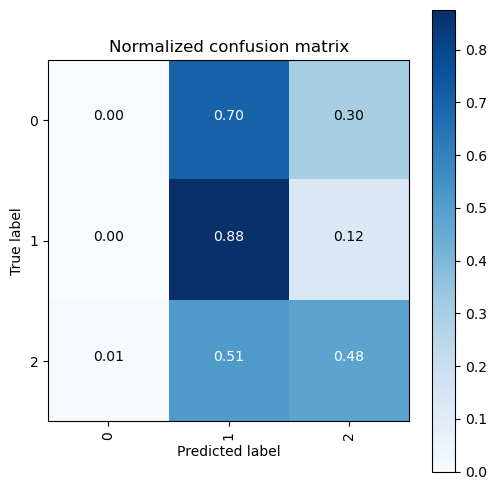

In [135]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, pred)
classes = np.unique(y_train)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))

plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()